In [3]:
!pip install espn-api fuzzywuzzy python-Levenshtein


In [4]:
from espn_api.football import League
from fuzzywuzzy import process

# ESPN league connection
LEAGUE_ID = 14090156
YEAR = 2024
SWID = "{D17F49D8-DBA5-4E20-A9FC-386D39E43540}"
ESPN_S2 = "AEAptpHcPydzE6ccnp%2BPZt8IaGHKr%2B%2Br8EFhnvy1tflOOqIsVSnnCRiCLc9k9gTKS5jPH7%2BU4ODdzKeaX6V7gt%2Bn0UlGs4PQrZ91S1ZELUOeFRDgdP61bYydJIXlmtF%2BXLa7IdKdpOh4lbX0z2WdKNtUeB5UZAqsmdOlOJRrqvxDs158SiEg3l3KvjalkV6sADoBw00bZhN7UxQraKh6mmPN4ohD3lHajUOMRxLhX80JYcKfjT%2FiyUwE2kc7zzBulq2RLOfqWwVwSvQGc2L4ffuaHYkBPj3YUSUSlUvS8htNegXVh4XIC2eezbaa%2FL%2BzZsY%3D"

league = League(league_id=LEAGUE_ID, year=YEAR, swid=SWID, espn_s2=ESPN_S2)

# Get rosters
teams = {team.team_name: team.roster for team in league.teams}
list(teams.keys())

['Guys Like Me',
 "Roy's Kavemen",
 'No Free Lunch',
 'The Haggetron 3000',
 "D'Tricks of D'Trade",
 "Vincenzo's Wincenzos",
 'Oneida Castle Moat Monsters',
 'Armed Rodgery',
 'Big Mac ',
 'Detroit Rock City',
 'Brach’s Jocks ',
 'Bear Down Serene Machine']

In [25]:
from google.colab import files
uploaded = files.upload()

import pandas as pd

csv_path = next(iter(uploaded))
rankings_df = pd.read_csv(csv_path, sep=',')

Saving fantasycalc_redraft_rankings.csv to fantasycalc_redraft_rankings (2).csv


In [26]:
# Build lookup of all drafted players to see who was ever drafted (and by whom)
all_drafted = {}
for team, picks in drafted_by_team.items():
    for name, round_num in picks:
        all_drafted[name] = team  # maps player -> team that drafted them

# Fuzzy match helper
def best_match(player_name, choices, threshold=90):
    match, score = process.extractOne(player_name, choices)
    return match if score >= threshold else None

# Build keeper candidates for all teams
keeper_options_by_team = {}

for team, roster in final_rosters.items():
    drafted = drafted_by_team.get(team, [])
    drafted_names = [name for name, _ in drafted]

    drafted_kept = []
    for name, round_num in drafted:
        match = best_match(name, roster)
        if match:
            # Skip 1st rounders
            if round_num <= 1:
                continue

            # Custom logic for Detroit Rock City (penalty: -2 rounds)
            if team == "Detroit Rock City":
                keeper_round = round_num - 2
            else:
                keeper_round = round_num - 1

            if keeper_round >= 1:
                drafted_kept.append((match, keeper_round))

    # Waiver adds = on final roster and not drafted by anyone
    waiver_kept = []
    for name in roster:
        drafted_by = best_match(name, all_drafted.keys())
        if not drafted_by:
            waiver_kept.append((name, 5))  # Waiver keeper round unchanged

    keeper_options = drafted_kept + waiver_kept
    keeper_options.sort(key=lambda x: x[1])  # sort by keeper round

    keeper_options_by_team[team] = keeper_options

In [55]:
# Step 4.5: Add keeper value relative to expected pick value
NUM_TEAMS = 12
draft_order = [team.team_name for team in sorted(league.teams, key=lambda t: t.final_standing, reverse=True)]

# Create a lookup: overall pick -> FantasyCalc value
fc_value_by_rank = dict(zip(rankings_df["overallRank"], rankings_df["value"]))

# Helper to convert (round, team_index) to overall pick number in snake draft
def get_overall_pick(round_num, team_index):
    if round_num % 2 == 1:  # odd rounds go 1 -> 12
        return (round_num - 1) * NUM_TEAMS + team_index + 1
    else:  # even rounds go 12 -> 1
        return (round_num) * NUM_TEAMS - team_index

# Evaluate surplus value for each keeper
keeper_values_by_team = {}

for team_index, team_name in enumerate(draft_order):
    keepers = keeper_options_by_team[team_name]
    values = []

    for player_name, keeper_round in keepers:
        # Get player's actual value
        player_row = rankings_df[rankings_df["name"].str.lower() == player_name.lower()]
        if player_row.empty:
            continue  # skip if no match in FantasyCalc

        player_value = player_row["value"].values[0]

        # Get expected value of pick they would replace
        pick_num = get_overall_pick(keeper_round, team_index)
        expected_value = fc_value_by_rank.get(pick_num, 0)

        surplus = player_value - expected_value
        values.append((player_name, keeper_round, surplus))

    # Sort by best surplus
    keeper_values_by_team[team_name] = sorted(values, key=lambda x: x[2], reverse=True)

In [56]:
for team, options in keeper_values_by_team.items():
    if not options:
        print(f"{team}: No eligible keepers")
    else:
        name, rnd, surplus = options[0]
        print(f"{team}: Best Keeper = {name} (Rd {rnd}), Surplus = {surplus:.0f}")

Roy's Kavemen: Best Keeper = Braelon Allen (Rd 14), Surplus = -32
Armed Rodgery: Best Keeper = Ladd McConkey (Rd 7), Surplus = 3192
Vincenzo's Wincenzos: Best Keeper = James Cook (Rd 4), Surplus = 1535
Big Mac : Best Keeper = Brock Bowers (Rd 9), Surplus = 4876
The Haggetron 3000: Best Keeper = Courtland Sutton (Rd 7), Surplus = 381
Bear Down Serene Machine: Best Keeper = Jayden Daniels (Rd 10), Surplus = 4262
Oneida Castle Moat Monsters: Best Keeper = Brian Thomas Jr. (Rd 8), Surplus = 5532
Guys Like Me: Best Keeper = Josh Jacobs (Rd 2), Surplus = -302
No Free Lunch: Best Keeper = Nico Collins (Rd 8), Surplus = 6243
Brach’s Jocks : Best Keeper = George Kittle (Rd 5), Surplus = 1642
D'Tricks of D'Trade: Best Keeper = De'Von Achane (Rd 9), Surplus = 6293
Detroit Rock City: Best Keeper = Lamar Jackson (Rd 3), Surplus = 2325


In [60]:
import ipywidgets as widgets
from IPython.display import display, HTML

keeper_dropdowns = {}

def format_keeper_option(player_name, round_num, surplus):
    color = "green" if surplus > 0 else ("red" if surplus < 0 else "black")
    surplus_str = f"{surplus:+.0f}"
    return f"{player_name} (Rd {round_num}, {surplus_str})"

for team in draft_order:
    options = keeper_values_by_team.get(team, [])

    # HTML display string -> (player_name, round)
    display_map = {}

    dropdown_options = []

    # Add "No keeper" as the first option
    no_keeper_html = "<span style='color:black'>No keeper</span>"
    dropdown_options.append(widgets.HTML(value=no_keeper_html))
    display_map["No keeper"] = None

    for player_name, round_num, surplus in options:
        label = format_keeper_option(player_name, round_num, surplus)
        dropdown_options.append(widgets.HTML(value=label))
        display_map[label] = (player_name, round_num)

    # Use a Dropdown widget with raw strings for selection, but display as HTML
    dropdown = widgets.Dropdown(
        options=["No keeper"] + [format_keeper_option(*vals) for vals in options],
        description=team[:15],  # limit label length
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='60%')
    )

    keeper_dropdowns[team] = dropdown
    display(dropdown)

Dropdown(description="Roy's Kavemen", layout=Layout(width='60%'), options=('No keeper', 'Braelon Allen (Rd 14,…

Dropdown(description='Armed Rodgery', layout=Layout(width='60%'), options=('No keeper', 'Ladd McConkey (Rd 7, …

Dropdown(description="Vincenzo's Winc", layout=Layout(width='60%'), options=('No keeper', 'James Cook (Rd 4, +…

Dropdown(description='Big Mac ', layout=Layout(width='60%'), options=('No keeper', 'Brock Bowers (Rd 9, +4876)…

Dropdown(description='The Haggetron 3', layout=Layout(width='60%'), options=('No keeper', 'Courtland Sutton (R…

Dropdown(description='Bear Down Seren', layout=Layout(width='60%'), options=('No keeper', 'Jayden Daniels (Rd …

Dropdown(description='Oneida Castle M', layout=Layout(width='60%'), options=('No keeper', 'Brian Thomas Jr. (R…

Dropdown(description='Guys Like Me', layout=Layout(width='60%'), options=('No keeper', 'Josh Jacobs (Rd 2, -30…

Dropdown(description='No Free Lunch', layout=Layout(width='60%'), options=('No keeper', 'Nico Collins (Rd 8, +…

Dropdown(description='Brach’s Jocks ', layout=Layout(width='60%'), options=('No keeper', 'George Kittle (Rd 5,…

Dropdown(description="D'Tricks of D'T", layout=Layout(width='60%'), options=('No keeper', "De'Von Achane (Rd 9…

Dropdown(description='Detroit Rock Ci', layout=Layout(width='60%'), options=('No keeper', 'Lamar Jackson (Rd 3…

In [65]:
# Collect selected keepers into a dict
selected_keepers = {}
for team, dropdown in keeper_dropdowns.items():
    val = dropdown.value
    if val != "No keeper" and val is not None:
        name = val.split(" (")[0]
        round_str = val.split("Rd ")[1].split(",")[0]
        keeper_round = int(round_str)
        selected_keepers[team] = (name, keeper_round)

# Remove keepers from rankings list
kept_names = [name for name, _ in selected_keepers.values()]
available_players_df = rankings_df[~rankings_df['name'].isin(kept_names)].copy()

# Reset index and sort by rank
available_players_df = available_players_df.sort_values("overallRank").reset_index(drop=True)

In [66]:
import numpy as np
import pandas as pd
from IPython.display import display

# Prepare post-keeper draft pool (sorted)
draft_pool = available_players_df.sort_values("overallRank").reset_index(drop=True).copy()
draft_pool["Pick"] = draft_pool.index + 1

# Value by pick number
value_by_pick = draft_pool.set_index("Pick")["value"]

# Moving average of value around each pick
window_size = 7
moving_avg = value_by_pick.rolling(window=window_size, center=True, min_periods=1).mean()

# Get Detroit Rock City’s snake draft picks
def get_detroit_picks(rounds=15):
    picks = []
    for rnd in range(1, rounds + 1):
        if rnd % 2 == 1:
            pick = (rnd - 1) * 12 + 12
        else:
            pick = (rnd - 1) * 12 + 1
        picks.append((rnd, pick))
    return picks

detroit_picks = get_detroit_picks()

# Get keeper info
my_team_name = "Detroit Rock City"
keeper_name, keeper_round = selected_keepers.get(my_team_name, (None, None))
keeper_pick_num = None
if keeper_round:
    keeper_pick_num = get_detroit_picks()[keeper_round - 1][1]  # convert round -> pick number

# Build pick analysis
analysis = []

for rnd, pick_num in detroit_picks:
    if pick_num > len(draft_pool) and (keeper_pick_num != pick_num):
        continue

    if keeper_pick_num == pick_num:
        # Insert keeper
        keeper_row = rankings_df[rankings_df["name"] == keeper_name]
        if not keeper_row.empty:
            value = keeper_row.iloc[0]["value"]
            avg_val = moving_avg.get(pick_num, 0)
            delta = value - avg_val
            tag = (
                "🟢 Great Keeper!" if delta >= 100 else
                "✅ Solid Keeper" if delta >= 0 else
                "🔴 Pricey Keeper?" if delta <= -150 else
                "⚠️ Below Avg Keeper"
            )
            analysis.append({
                "Round": rnd,
                "Pick #": pick_num,
                "Projected Player": keeper_name + " (Keeper)",
                "Value": value,
                "Local Avg": avg_val,
                "Δ from Avg": delta,
                "Recommendation": tag
            })
        continue

    player_row = draft_pool.loc[pick_num - 1]
    name = player_row["name"]
    value = player_row["value"]
    avg_val = moving_avg.get(pick_num, 0)
    delta = value - avg_val

    tag = (
        "🟢 Great Value — Hold" if delta >= 100 else
        "✅ Solid — Safe Pick" if delta >= 0 else
        "🔴 Trade Down?" if delta <= -150 else
        "⚠️ Below Avg — Caution"
    )

    analysis.append({
        "Round": rnd,
        "Pick #": pick_num,
        "Projected Player": name,
        "Value": value,
        "Local Avg": avg_val,
        "Δ from Avg": delta,
        "Recommendation": tag
    })

# Display table
analysis_df = pd.DataFrame(analysis)
display(analysis_df)

,Round,Pick #,Projected Player,Value,Local Avg,Δ from Avg,Recommendation
0,1,12,Josh Allen,7465,7605.428571,-140.428571,⚠️ Below Avg — Caution
1,2,13,Puka Nacua,7446,7338.571429,107.428571,🟢 Great Value — Hold
2,3,36,Terry McLaurin,3683,3648.428571,34.571429,✅ Solid — Safe Pick
3,4,37,Patrick Mahomes,3545,3566.285714,-21.285714,⚠️ Below Avg — Caution
4,5,60,Justin Herbert,1913,1936.714286,-23.714286,⚠️ Below Avg — Caution
5,6,61,Jaxon Smith-Njigba (Keeper),4094,1884.428571,2209.571429,🟢 Great Keeper!
6,7,84,Zach Charbonnet,1095,1072.714286,22.285714,✅ Solid — Safe Pick
7,8,85,Cooper Kupp,1069,1049.142857,19.857143,✅ Solid — Safe Pick
8,9,108,Trevor Lawrence,626,628.428571,-2.428571,⚠️ Below Avg — Caution
9,10,109,Matthew Golden,623,612.428571,10.571429,✅ Solid — Safe Pick


/tmp/ipython-input-67-2359593148.py:50: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


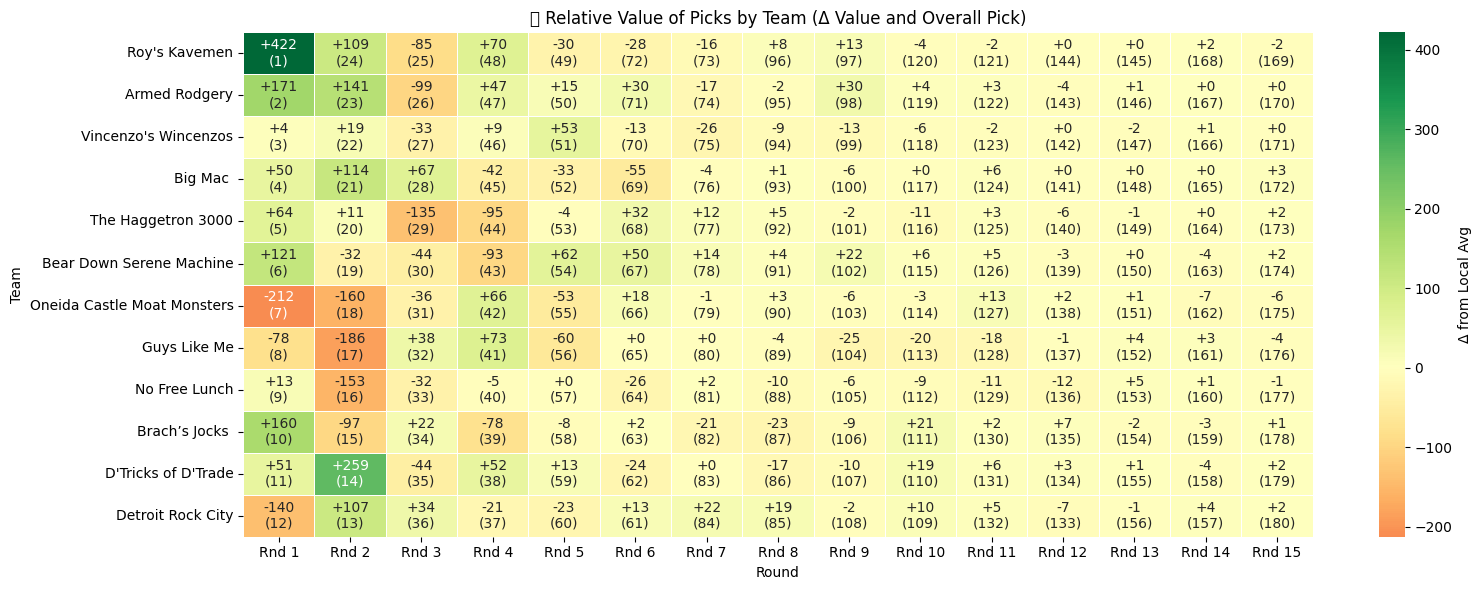

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Define constants
NUM_TEAMS = 12
NUM_ROUNDS = 15
teams = draft_order

# Create annotated and value tables
annot_table = []
value_table = []

value_by_pick = draft_pool.set_index("Pick")["value"]
moving_avg = value_by_pick.rolling(window=7, center=True, min_periods=1).mean()

for team_index, team in enumerate(teams):
    row_annots = []
    row_values = []
    for rnd in range(1, NUM_ROUNDS + 1):
        if rnd % 2 == 1:
            pick_num = (rnd - 1) * NUM_TEAMS + team_index + 1
        else:
            pick_num = (rnd - 1) * NUM_TEAMS + (NUM_TEAMS - team_index)

        if pick_num <= len(draft_pool):
            value = value_by_pick.get(pick_num, 0)
            avg_val = moving_avg.get(pick_num, 0)
            delta = value - avg_val
            label = f"{int(delta):+}\n({pick_num})"
            row_annots.append(label)
            row_values.append(delta)
        else:
            row_annots.append("")
            row_values.append(np.nan)
    annot_table.append(row_annots)
    value_table.append(row_values)

# Create DataFrame for heatmap
relative_value_matrix = pd.DataFrame(value_table, index=teams, columns=[f"Rnd {i+1}" for i in range(NUM_ROUNDS)])

# Plot the heatmap
plt.figure(figsize=(16, 6))
sns.heatmap(relative_value_matrix, annot=np.array(annot_table), fmt="", cmap="RdYlGn", center=0,
            linewidths=0.5, cbar_kws={'label': 'Δ from Local Avg'})
plt.title("📊 Relative Value of Picks by Team (Δ Value and Overall Pick)")
plt.xlabel("Round")
plt.ylabel("Team")
plt.tight_layout()
plt.show()


In [73]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# ---- CONFIG ----
NUM_TEAMS = 12
NUM_ROUNDS = 15
my_team = "Detroit Rock City"

# Snake draft helper
def get_overall_pick(round_num, team_index):
    if round_num % 2 == 1:
        return (round_num - 1) * NUM_TEAMS + team_index + 1
    else:
        return round_num * NUM_TEAMS - team_index

# Draft order (worst to best)
draft_order = [team.team_name for team in sorted(league.teams, key=lambda t: t.final_standing, reverse=True)]
team_index_map = {team: i for i, team in enumerate(draft_order)}

# Build pick list for each team from cleaned draft_pool
team_picks = {}
valid_picks = set(draft_pool["Pick"])
for team, idx in team_index_map.items():
    picks = []
    for rnd in range(1, NUM_ROUNDS + 1):
        pick_num = get_overall_pick(rnd, idx)
        if pick_num in valid_picks:
            picks.append(pick_num)
    team_picks[team] = picks

# ---- Widgets ----
opponent_dropdown = widgets.Dropdown(
    options=[t for t in draft_order if t != my_team],
    description="Trade with:"
)

my_pick_checkboxes = []
opp_pick_checkboxes = []

my_checkboxes_box = widgets.VBox()
opp_checkboxes_box = widgets.VBox()
trade_output = widgets.Output()

def create_checkboxes(picks):
    return [
        widgets.Checkbox(
            value=False,
            description=f"#{p} (val: {int(draft_pool.loc[draft_pool['Pick'] == p, 'value'].values[0])})",
            indent=False
        )
        for p in sorted(picks)
    ]

def update_picks(*args):
    opponent = opponent_dropdown.value
    my_picks = team_picks[my_team]
    their_picks = team_picks[opponent]

    global my_pick_checkboxes, opp_pick_checkboxes
    my_pick_checkboxes = create_checkboxes(my_picks)
    opp_pick_checkboxes = create_checkboxes(their_picks)

    my_checkboxes_box.children = my_pick_checkboxes
    opp_checkboxes_box.children = opp_pick_checkboxes

def evaluate_trade(_):
    with trade_output:
        clear_output()

        mine = [int(cb.description.split()[0][1:]) for cb in my_pick_checkboxes if cb.value]
        theirs = [int(cb.description.split()[0][1:]) for cb in opp_pick_checkboxes if cb.value]

        my_val = sum(draft_pool.loc[draft_pool["Pick"] == p, "value"].values[0] for p in mine)
        their_val = sum(draft_pool.loc[draft_pool["Pick"] == p, "value"].values[0] for p in theirs)
        delta = their_val - my_val

        print(f"📤 You Give ({my_team}): {sorted(mine)} | Total Value: {my_val:.0f}")
        print(f"📥 You Get ({opponent_dropdown.value}): {sorted(theirs)} | Total Value: {their_val:.0f}")
        print(f"⚖️ Net Gain: {delta:+.0f}")
        if delta > 0:
            print("✅ This trade favors you.")
        elif delta < 0:
            print("❌ This trade favors them.")
        else:
            print("➖ This trade is roughly even.")

# Setup
opponent_dropdown.observe(update_picks, names='value')
update_picks()

# Buttons
eval_button = widgets.Button(description="Evaluate Trade", button_style='success')
eval_button.on_click(evaluate_trade)

# ---- Display UI ----
display(widgets.HTML("<h3>🤝 Draft Pick Trade Evaluator — Detroit Rock City</h3>"))
display(opponent_dropdown)
display(widgets.HBox([my_checkboxes_box, opp_checkboxes_box]))
display(eval_button)
display(trade_output)

HTML(value='<h3>🤝 Draft Pick Trade Evaluator — Detroit Rock City</h3>')

Dropdown(description='Trade with:', options=("Roy's Kavemen", 'Armed Rodgery', "Vincenzo's Wincenzos", 'Big Ma…

Button(button_style='success', description='Evaluate Trade', style=ButtonStyle())

Output()